# load, process, and grid ERDDAP 

An attempt make the real-time glider data easier to work with. Once its in this format, it should be easy to grab sections using the `.sel(date = slice() )` methods of xarray. You should also have an easier time calcuating stuff, and plotting agaist time, lat or lon

This is a little fast and loose, so caveat emptor for science!

## to do:
We could(should) just convert this into a function to be run by another notebook. 
input to that function would probably be the glider dataset ID, and the variables you want

In [1]:
import xarray as xr
import pandas as pd
from erddapy import ERDDAP
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

from scipy.signal import find_peaks

from scipy import stats

In [20]:
# this creates a link to the RUCOOL server:
e = ERDDAP(
    server="http://slocum-data.marine.rutgers.edu/erddap",
    protocol="tabledap",
    response="nc",
)

# get the science data:
e.dataset_id = 'ru29-20200908T1623-profile-sci-rt'

# this connects to the data and load into an pandas dataframe
ds = e.to_pandas()
# remove the spaces from the column names
ds.columns = ds.columns.str.split(' ').str[0]

# get the time to be a datetime object
ds['time'] = pd.to_datetime(ds['time'])

# put the times in order
ds = ds.sort_values(by=['time'])

print(ds.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 472171 entries, 0 to 472170
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   time                           472171 non-null  datetime64[ns, UTC]
 1   latitude                       472171 non-null  float64            
 2   longitude                      472171 non-null  float64            
 3   depth                          273181 non-null  float64            
 4   trajectory                     472171 non-null  object             
 5   source_file                    472171 non-null  object             
 6   beta_700nm                     134175 non-null  float64            
 7   cdom                           134177 non-null  float64            
 8   chlorophyll_a                  134177 non-null  float64            
 9   conductivity                   273155 non-null  float64            
 10  crs     

(0.0, 10000.0)

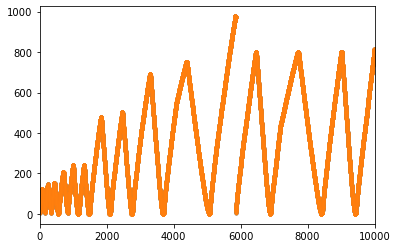

In [3]:

# fill nans in dpeth for the profile breakup
interpd = ds.depth.interpolate()

plt.plot(ds.depth.values, '.')
plt.plot(interpd.values, '.')
plt.xlim([0, 1e4])



In [4]:
# find the top and bottom of each profile
apogee, prop = find_peaks(interpd.values,  threshold=None, distance=None, prominence=50)

perogee, prop = find_peaks(-1*interpd.values,  threshold=None, distance=None, prominence=50)

# stack the index of the turning points into one vector
turns = np.sort(np.append(apogee, perogee ))
turns.shape

(703,)

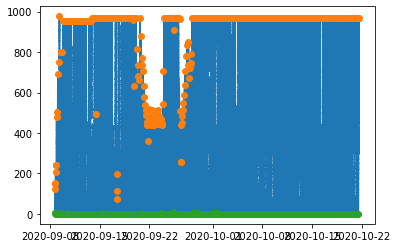

In [5]:
# check your work
plt.plot(ds.time, ds.depth)
plt.plot(ds.time[apogee], ds.depth[apogee], 'o')
plt.plot(ds.time[perogee], ds.depth[perogee], 'o')


(0.0, 1000.0)

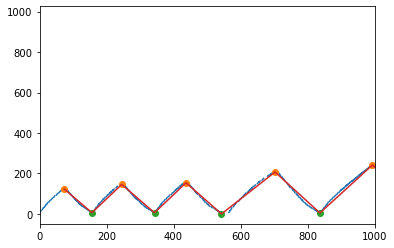

In [6]:
# look in more detail
plt.plot( ds.depth)
plt.plot( ds.depth[apogee], 'o')
plt.plot( ds.depth[perogee], 'o')
plt.plot( ds.depth[turns])
plt.xlim([0, 1e4 ])

# plt.xlim([4.2e5, 4.5e5 ])

# GRID!

build a useful dataset for analysis. We will grid some stuff in time and depth, then grid some 1-d stuff to make coordinates and put it all together into an xarray dataset

## start with '2D' gridding

here we are going to bin (grid) stuff that has 2 dimentions: time and depth

for example: temp, salin, ...

In [7]:
# this is your depth grid, you can set:
zgrd = np.arange(0,1000,5)

# list of variables to grid in 2d:
# you choose from the columns of the science data
dataz = ['potential_temperature', 'salinity', 'cdom', 'chlorophyll_a', 'beta_700nm']


# this is a dict to hold our gridded stuff
# until we make a dataset later
d2 = {}

# loop on the variables you want to bin
for varz in dataz:    
    values = ds[varz] # grab some data
    
    #this thing below bins the data
    ret = stats.binned_statistic_2d(ds.index.values, ds.depth, values, statistic='mean', bins=[ turns, zgrd ])
    d2[varz] = ret.statistic.T
    
d2.keys()

dict_keys(['potential_temperature', 'salinity', 'cdom', 'chlorophyll_a', 'beta_700nm'])

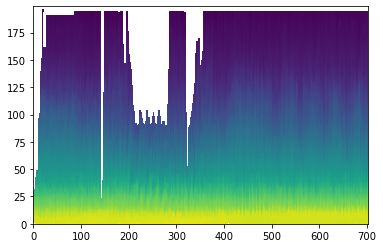

In [8]:
# make a quick plot of the results
plt.pcolormesh(d2['potential_temperature'] )
# plt.xlim([0, 40])

## next: bin some '1D' stuff
these are things that dont have a depth dimention:
like, time, lat, lon, u, v, ...

In [9]:
# things to bin in the x direction
oneDvars = ['latitude','longitude', 'time', 'u', 'v']

# NB: u, v only have one value per dive sequence, so only half the number profiles!
# actually, its weirder than that... not sure there are more than half...

# dict to hold our 1d bins
d1 = {}

# loop on 1d stuff:
for thing in oneDvars:    
    if thing == 'time':
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].astype(int), statistic = 'mean', bins=turns)
        bin_means = pd.to_datetime(bin_means)
    else:
    
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].values, statistic = np.nanmean, bins=turns)
    d1[thing] = bin_means
    
    d1.keys()

/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])
/Users/beaird/anaconda3/envs/fm2020/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


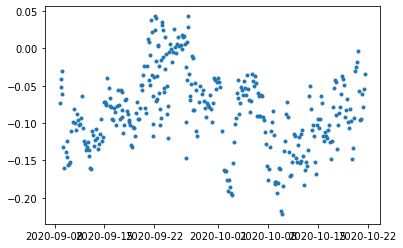

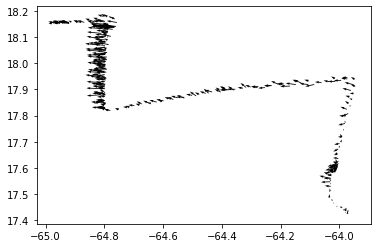

In [10]:

plt.plot(d1['time'], d1['u'],'.')

plt.figure()
plt.quiver(d1['longitude'], d1['latitude'], d1['u'], d1['v'])

340  non-nan velocites


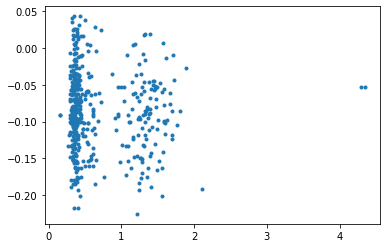

In [11]:
# how many non-nan u and v's?
# this is confusing
print( np.count_nonzero( ~np.isnan(d1['v']) ) , ' non-nan velocites')

plt.plot(interpd.values, ds.u.values, '.')

# put it all together

Now we can add these things together into an xarray dataset that will be easier to work with

In [12]:

# need the depth grid centers
zgrd_ctr = zgrd[:-1] + np.diff(zgrd).mean()/2

# create the dataset
ds_gridded = xr.Dataset( coords = {'date': d1['time'].values,'depth': zgrd_ctr ,
                           'lat': ('date', d1['latitude']),
                           'lon': ('date', d1['longitude'])
                          },
               data_vars = {'u': ('date', d1['u']), 
                           'v': ('date', d1['v'])})

# add the other data
for varz in dataz:
    ds_gridded[varz] = ( ('depth', 'date'),d2[varz] )

    
# thie line below will save the netcdf if you want to work with it in another notebook    
# ds_gridded.to_netcdf('./glider_gridded.nc')

ds_gridded


<xarray.Dataset>
Dimensions:                (date: 702, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-08T16:45:31.84337305...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.18 18.18 18.18 ... 17.86 17.85
    lon                    (date) float64 -64.8 -64.81 -64.8 ... -64.8 -64.8
Data variables:
    u                      (date) float64 nan nan nan ... -0.05383 nan -0.03486
    v                      (date) float64 nan nan nan ... 0.02627 nan 0.02168
    potential_temperature  (depth, date) float64 nan nan nan nan ... nan nan nan
    salinity               (depth, date) float64 nan nan nan nan ... nan nan nan
    cdom                   (depth, date) float64 nan nan nan nan ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan nan nan nan ... nan nan nan
    beta_700nm             (depth, date) float64 nan nan nan nan ... nan nan nan

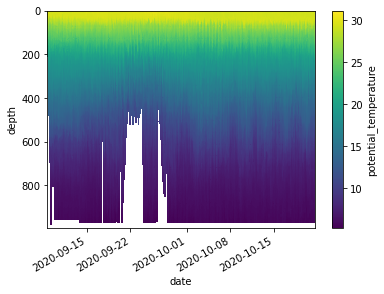

In [19]:
ds_gridded.potential_temperature.plot( yincrease=False)

# make a section plot
this should be easier now, but this belongs in another notebook

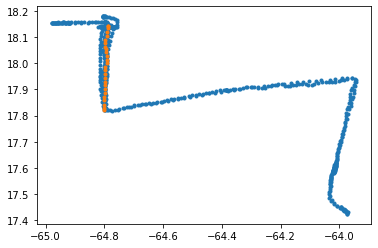

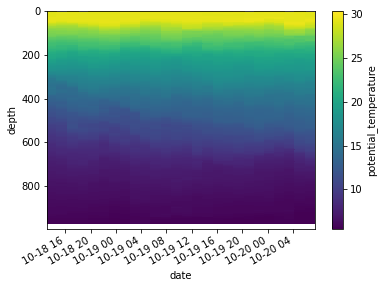

In [33]:
# can we select a time?
section = ds_gridded.sel( date = slice('2020-10-18T13:04:29.446530048','2020-10-20T07:42:28.419889920' ) )

plt.figure()
plt.plot(ds_gridded.lon, ds_gridded.lat,'.')
plt.plot(section.lon, section.lat,'.')

plt.figure()
section.potential_temperature.plot(yincrease=False)